<a href="https://colab.research.google.com/github/tinayem01/motor-insurance-claim-prediction/blob/main/Insurance_Claims_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install**

In [ ]:
!pip install feature_engine

     |████████████████████████████████| 180 kB 4.2 MB/s 
     |████████████████████████████████| 9.5 MB 40.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [ ]:
!pip install imblearn

In [ ]:
import pandas as pd
import numpy as np
from sklearn import model_selection
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline, ensemble, tree, neighbors, svm, impute, preprocessing, model_selection
from sklearn.experimental import enable_iterative_imputer
from feature_engine import encoding, transformation, outliers, imputation
import datetime as dt
from sklearn import metrics, feature_selection
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import  Pipeline
import xgboost
import lightgbm
from IPython.display import display

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# **Read Data**

In [ ]:
df  = pd.read_csv('/content/drive/MyDrive/Datasets/Project/car_insurance_claim.csv')
df['CLM_AMT'] = df.CLM_AMT.str.replace('$','').str.replace(',','').astype('float')
df.head(3)

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
0,63581743,0,16MAR39,60.0,0,11.0,"$67,349",No,$0,z_No,M,PhD,Professional,14,Private,"$14,230",11,Minivan,yes,"$4,461",2,No,3,0.0,18.0,0,Highly Urban/ Urban
1,132761049,0,21JAN56,43.0,0,11.0,"$91,449",No,"$257,252",z_No,M,z_High School,z_Blue Collar,22,Commercial,"$14,940",1,Minivan,yes,$0,0,No,0,0.0,1.0,0,Highly Urban/ Urban
2,921317019,0,18NOV51,48.0,0,11.0,"$52,881",No,$0,z_No,M,Bachelors,Manager,26,Private,"$21,970",1,Van,yes,$0,0,No,2,0.0,10.0,0,Highly Urban/ Urban


In [ ]:
df.sample(3)

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CLM_AMT,CAR_AGE,CLAIM_FLAG,URBANICITY
7733,376805275,0,18DEC41,57.0,0,14.0,"$100,985",No,"$280,768",Yes,z_F,Masters,Lawyer,8,Private,"$22,710",6,z_SUV,no,"$4,531",3,No,2,0.0,15.0,0,Highly Urban/ Urban
8105,217188837,0,09FEB53,46.0,0,7.0,"$100,251",No,"$316,455",Yes,M,z_High School,Manager,47,Private,"$12,430",10,Minivan,yes,$0,0,No,0,0.0,1.0,0,Highly Urban/ Urban
8925,494349872,0,04FEB48,51.0,0,9.0,"$78,283",No,"$262,744",Yes,M,Bachelors,Manager,5,Private,"$15,380",4,Minivan,yes,$0,0,No,4,0.0,12.0,0,Highly Urban/ Urban


In [ ]:
df.shape

(10302, 27)

# **Split Data**

In [ ]:
xtrain, xtest, ytrain_claim, ytest_claim, ytrain_amt, ytest_amt = model_selection.train_test_split(df.drop(columns = ['CLAIM_FLAG','CLM_AMT']),
                                                                                                   df.CLAIM_FLAG, df.CLM_AMT, test_size = 0.1,
                                                                                                   random_state = 123)

In [ ]:
[xtrain.shape, xtest.shape, ytrain_claim.shape, ytest_claim.shape, ytrain_amt.shape, ytest_amt.shape]

[(9271, 25), (1031, 25), (9271,), (1031,), (9271,), (1031,)]

In [ ]:
pd.concat([ytrain_claim.value_counts() / len(ytrain_claim),ytest_claim.value_counts()/len(ytest_claim)],axis  = 1)

,CLAIM_FLAG,CLAIM_FLAG
0,0.732823,0.739088
1,0.267177,0.260912


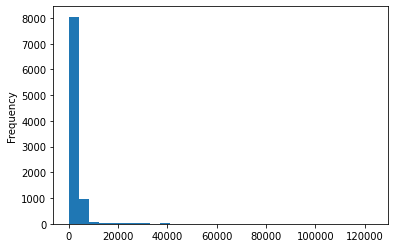

In [ ]:
ytrain_amt.plot.hist(bins = 30)
plt.show()

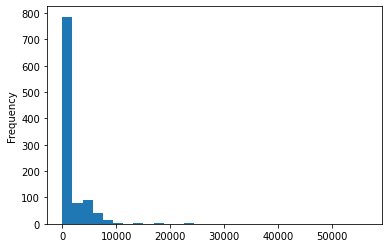

In [ ]:
ytest_amt.plot.hist(bins = 30)
plt.show()

In [ ]:
train = pd.concat([xtrain,ytrain_claim,ytrain_amt],axis = 1)
train.sample(3)

,ID,KIDSDRIV,BIRTH,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY,CLAIM_FLAG,CLM_AMT
9610,34418052,0,13MAR51,48.0,0,11.0,"$53,350",No,"$220,481",Yes,M,z_High School,Manager,5,Private,"$1,500",4,Minivan,no,$0,0,No,1,7.0,Highly Urban/ Urban,0,0.0
1803,688381462,0,18FEB64,35.0,0,13.0,"$7,163",No,$0,z_No,M,z_High School,Student,50,Commercial,"$6,580",6,Pickup,yes,$0,0,No,1,9.0,Highly Urban/ Urban,1,2081.0
9092,877748562,0,24SEP45,54.0,0,13.0,"$71,579",No,"$257,342",Yes,M,PhD,Manager,46,Commercial,"$18,560",3,Van,no,"$9,514",4,No,0,13.0,Highly Urban/ Urban,0,0.0


# **Data Types**

In [ ]:
xtrain.dtypes

ID              int64
KIDSDRIV        int64
BIRTH          object
AGE           float64
HOMEKIDS        int64
YOJ           float64
INCOME         object
PARENT1        object
HOME_VAL       object
MSTATUS        object
GENDER         object
EDUCATION      object
OCCUPATION     object
TRAVTIME        int64
CAR_USE        object
BLUEBOOK       object
TIF             int64
CAR_TYPE       object
RED_CAR        object
OLDCLAIM       object
CLM_FREQ        int64
REVOKED        object
MVR_PTS         int64
CAR_AGE       float64
URBANICITY     object
dtype: object

In [ ]:
print(f'There are {len(xtrain.columns)} features')

There are 25 features


In [ ]:
xtrain.describe(exclude = [np.number]).T

,count,unique,top,freq
BIRTH,9271,6145,20OCT60,8
INCOME,8757,7408,$0,718
PARENT1,9271,2,No,8080
HOME_VAL,8759,5764,$0,2606
MSTATUS,9271,2,Yes,5587
GENDER,9271,2,z_F,4987
EDUCATION,9271,5,z_High School,2643
OCCUPATION,8676,8,z_Blue Collar,2053
CAR_USE,9271,2,Private,5855
BLUEBOOK,9271,2886,"$1,500",188


- Convert `BIRTH` to age
- remove `$` and `,` in `INCOME, HOME_VAL, BLUEBOOK, OLDCLAIM` and cast it to float


In [ ]:
money_columns = ['INCOME','HOME_VAL','BLUEBOOK','OLDCLAIM']

In [ ]:
def cast_money_columns_to_float(s):
  if s.dtypes == np.object:
    return s.str.replace(r'[$|,]','').astype('float')
  return s

# def fix_birth(s):
#   if isinstance(s,str):
#     return (pd.Timestamp(dt.date.today()).year - pd.to_datetime(s[:5] + '19' + s[5:],format = '%d%b%Y').year)

In [ ]:
def preprocess(df):
  '''This function saves in place and returns the result'''
  df[money_columns] = df[money_columns].apply(cast_money_columns_to_float)
  if 'ID' in df.columns:
    df = df.drop(columns =  ['BIRTH','ID'])
  return df

In [ ]:
xtrain = preprocess(xtrain)
xtest = preprocess(xtest)

# **Descriptive Statistics**

In [ ]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
ID,9271.0,4.951788e+08,2.865226e+08,63175.0,243070211.5,495332659.0,740301438.0,999926368.0
KIDSDRIV,9271.0,1.685902e-01,5.051508e-01,0.0,0.0,0.0,0.0,4.0
AGE,9264.0,4.485373e+01,8.612076e+00,16.0,39.0,45.0,51.0,81.0
HOMEKIDS,9271.0,7.214971e-01,1.116171e+00,0.0,0.0,0.0,1.0,5.0
YOJ,8769.0,1.049014e+01,4.112018e+00,0.0,9.0,11.0,13.0,23.0
TRAVTIME,9271.0,3.346489e+01,1.588910e+01,5.0,22.0,33.0,44.0,142.0
TIF,9271.0,5.311185e+00,4.099875e+00,1.0,1.0,4.0,7.0,25.0
CLM_FREQ,9271.0,8.025024e-01,1.153550e+00,0.0,0.0,0.0,2.0,5.0
MVR_PTS,9271.0,1.719987e+00,2.170089e+00,0.0,0.0,1.0,3.0,13.0
CAR_AGE,8691.0,8.305028e+00,5.708859e+00,-3.0,1.0,8.0,12.0,28.0


In [ ]:
xtrain[money_columns].apply(cast_money_columns_to_float).describe()

,INCOME,HOME_VAL,BLUEBOOK,OLDCLAIM
count,8757.000000,8759.000000,9271.000000,9271.000000
mean,61573.519699,154930.854664,15634.678028,4063.426383
std,47300.548081,129131.650309,8424.112953,8769.209944
min,0.000000,0.000000,1500.000000,0.000000
25%,27684.000000,0.000000,9175.000000,0.000000
50%,53455.000000,160959.000000,14390.000000,0.000000
75%,86227.000000,238945.000000,20890.000000,4677.000000
max,367030.000000,885282.000000,69740.000000,57037.000000


In [ ]:
xtrain.drop(columns = money_columns).describe(exclude = [np.number])

,PARENT1,MSTATUS,GENDER,EDUCATION,OCCUPATION,CAR_USE,CAR_TYPE,RED_CAR,REVOKED,URBANICITY
count,9271,9271,9271,9271,8676,9271,9271,9271,9271,9271
unique,2,2,2,5,8,2,6,2,2,2
top,No,Yes,z_F,z_High School,z_Blue Collar,Private,z_SUV,no,No,Highly Urban/ Urban
freq,8080,5587,4987,2643,2053,5855,2580,6588,8147,7440


# **Missing Values**

In [ ]:
isnull = xtrain.isnull().mean().sort_values(ascending = False)
isnull[isnull > 0]

OCCUPATION    0.064179
CAR_AGE       0.062561
INCOME        0.055442
HOME_VAL      0.055226
YOJ           0.054147
AGE           0.000755
dtype: float64

In [ ]:
xtrain[isnull[isnull > 0].index]

,OCCUPATION,CAR_AGE,INCOME,HOME_VAL,YOJ,AGE
2647,NaN,19.0,93709.0,0.0,8.0,51.0
8983,Student,5.0,0.0,0.0,0.0,52.0
6935,NaN,13.0,137417.0,385800.0,12.0,42.0
2374,Student,6.0,0.0,0.0,NaN,42.0
10005,Clerical,6.0,20887.0,159568.0,13.0,48.0
...,...,...,...,...,...,...
9785,z_Blue Collar,1.0,55087.0,230249.0,12.0,49.0
7763,Clerical,9.0,28107.0,0.0,12.0,47.0
5218,Student,1.0,7806.0,0.0,11.0,34.0
1346,Clerical,1.0,13003.0,104742.0,15.0,24.0


- Use KNN or Iterative imputer for `INCOME, HOME_VAL, YOJ,CAR_AGE`
- Bespoke category for `OCCUPATION`

# **Cardinality**

In [ ]:
cat_features = xtrain.select_dtypes('object').columns.tolist()
num_features = xtrain.select_dtypes('number').columns.tolist()

In [ ]:
len(cat_features) + len(num_features)  == len(xtrain.columns)

True

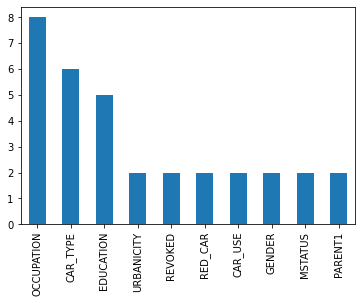

In [ ]:
xtrain[cat_features].nunique().sort_values(ascending = False).plot.bar()
plt.show()

In [ ]:
xtrain.GENDER.value_counts()

z_F    4987
M      4284
Name: GENDER, dtype: int64

# **Rare Rabels**

In [ ]:
for feature in cat_features:
  print(f"""
****************************
          {feature}
****************************""")
  print(xtrain[feature].value_counts(dropna = False)/len(xtrain))
  print()


****************************
          PARENT1
****************************
No     0.871535
Yes    0.128465
Name: PARENT1, dtype: float64


****************************
          MSTATUS
****************************
Yes     0.602632
z_No    0.397368
Name: MSTATUS, dtype: float64


****************************
          GENDER
****************************
z_F    0.537914
M      0.462086
Name: GENDER, dtype: float64


****************************
          EDUCATION
****************************
z_High School    0.285083
Bachelors        0.276669
Masters          0.200733
<High School     0.146047
PhD              0.091468
Name: EDUCATION, dtype: float64


****************************
          OCCUPATION
****************************
z_Blue Collar    0.221443
Clerical         0.153813
Professional     0.138173
Manager          0.123072
Lawyer           0.099018
Student          0.086830
Home Maker       0.082192
NaN              0.064179
Doctor           0.031280
Name: OCCUPATION, dtype:

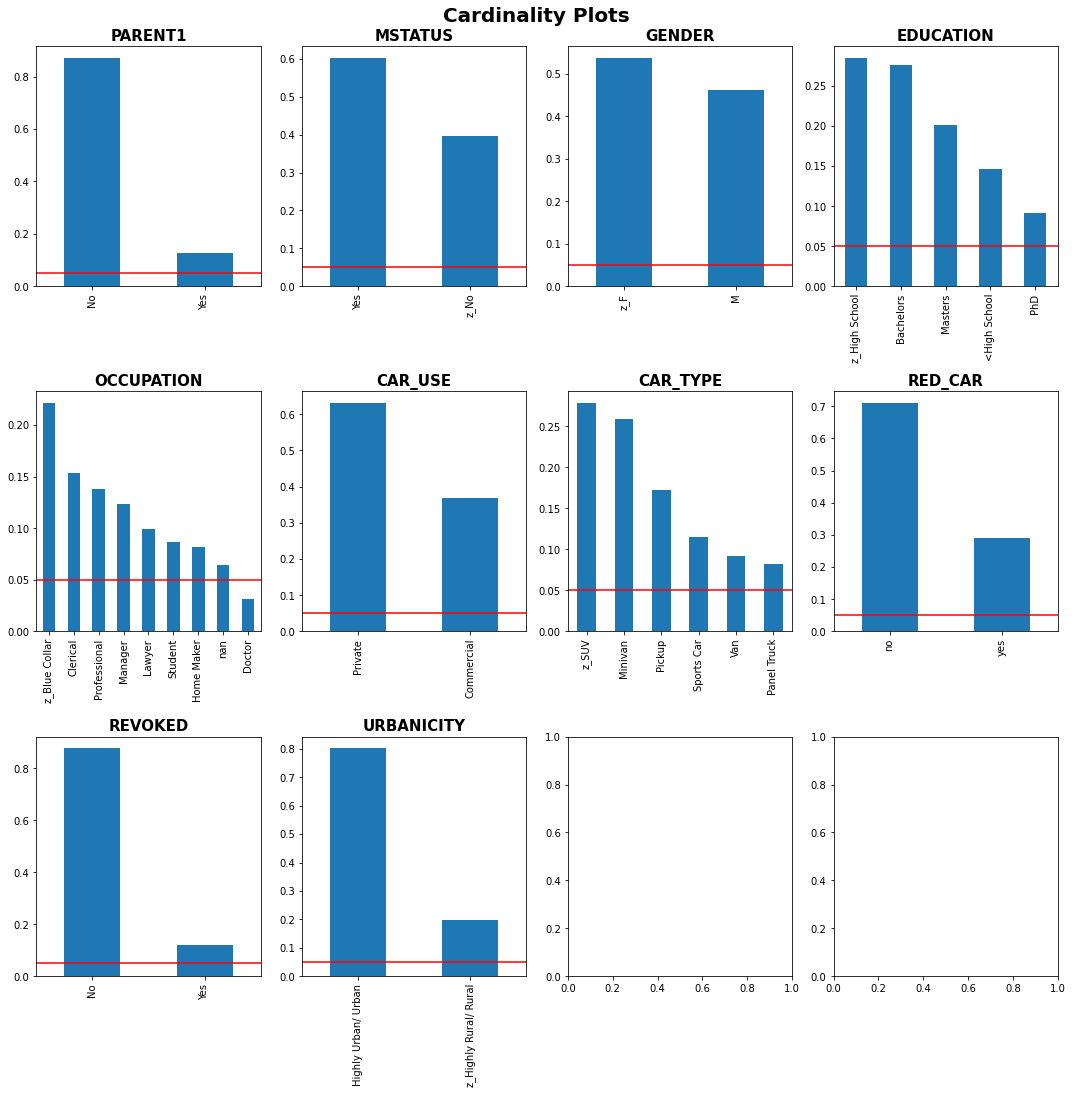

In [ ]:
cols = 4
rows = np.int(np.ceil(len(cat_features)/cols))
fig, axs = plt.subplots(rows,cols, figsize=(15,15))
feature_index = 0
for i in range(rows):
  for j in range(cols):
    label_freq = xtrain[cat_features[feature_index]].value_counts(dropna=False)/len(xtrain)
    label_freq.plot.bar(ax=axs[i,j])
    axs[i,j].set_title(cat_features[feature_index], size=15, fontweight='bold')
    axs[i,j].axhline(y=0.05, color='red')
    feature_index += 1
    if feature_index == len(cat_features):
      break
fig.suptitle('Cardinality Plots', size=20, fontweight='bold', y=1.01)
fig.tight_layout()
fig.savefig('cardinality plot.png',bbox_inches = 'tight')
fig.show()

- There are no rare labels at a threshold of 5%

# **Outlier Detection**

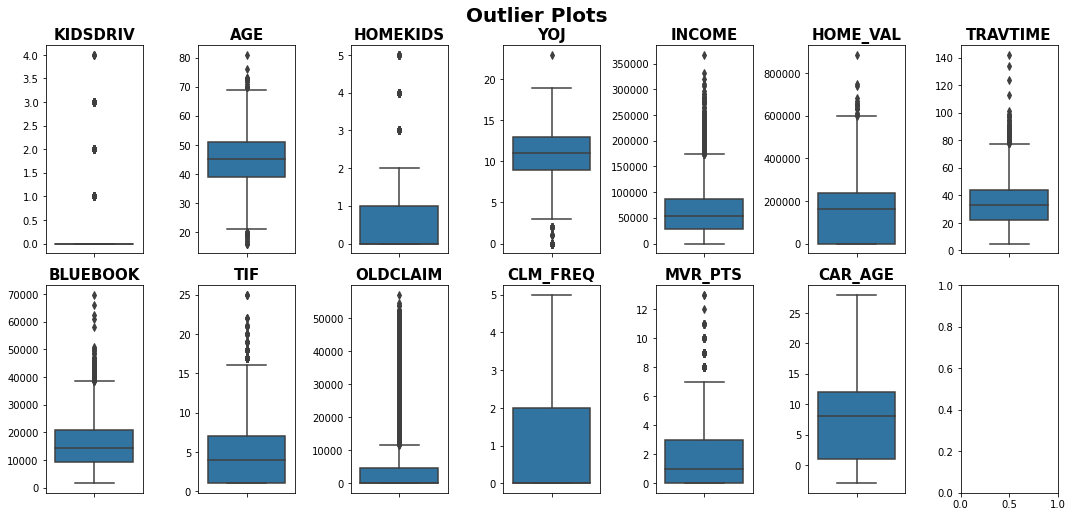

In [ ]:
xtrain_ = xtrain.copy()
xtrain_[money_columns] = xtrain[money_columns].apply(cast_money_columns_to_float)
cols = 7
rows = int(np.ceil(len(num_features)/cols))
fig, axs = plt.subplots(rows,cols, figsize=(15,7))
feature_index = 0
for i in range(rows):
  for j in range(cols):
    sns.boxplot(y = xtrain_[num_features[feature_index]], ax = axs[i,j])
    axs[i, j].set_title(num_features[feature_index], size = 15, fontweight = "bold")
    axs[i,j].set_ylabel(None)
    feature_index +=1
    if feature_index == len(num_features):
      break
fig.suptitle('Outlier Plots', size=20, fontweight='bold', y=1.02)
fig.tight_layout()
fig.savefig('oultier detection.png',bbox_inches = 'tight')
fig.show()

# **Feature Magnitude**

In [ ]:
xtrain_[num_features].max() - xtrain_[num_features].min()

KIDSDRIV         4.0
AGE             65.0
HOMEKIDS         5.0
YOJ             23.0
INCOME      367030.0
HOME_VAL    885282.0
TRAVTIME       137.0
BLUEBOOK     68240.0
TIF             24.0
OLDCLAIM     57037.0
CLM_FREQ         5.0
MVR_PTS         13.0
CAR_AGE         31.0
dtype: float64

- `MinMax` to `range(0,1)`

# **Variable Distribution**

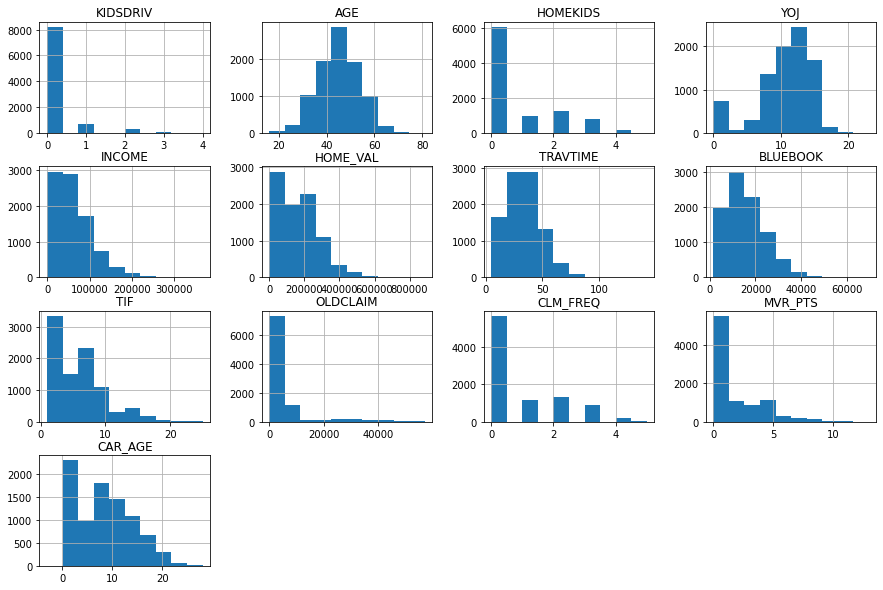

In [ ]:
xtrain_.hist(figsize = (15,10))
plt.savefig('variable dist.png')
plt.show()

- `MinMaxScaler` every numeric
- `np.cbrt` to `INCOME, HOME_VAL, TRAVTIME,BLUEBOOK,TIF,OLDCLAIM,MVR_PTS,CAR_AGE`

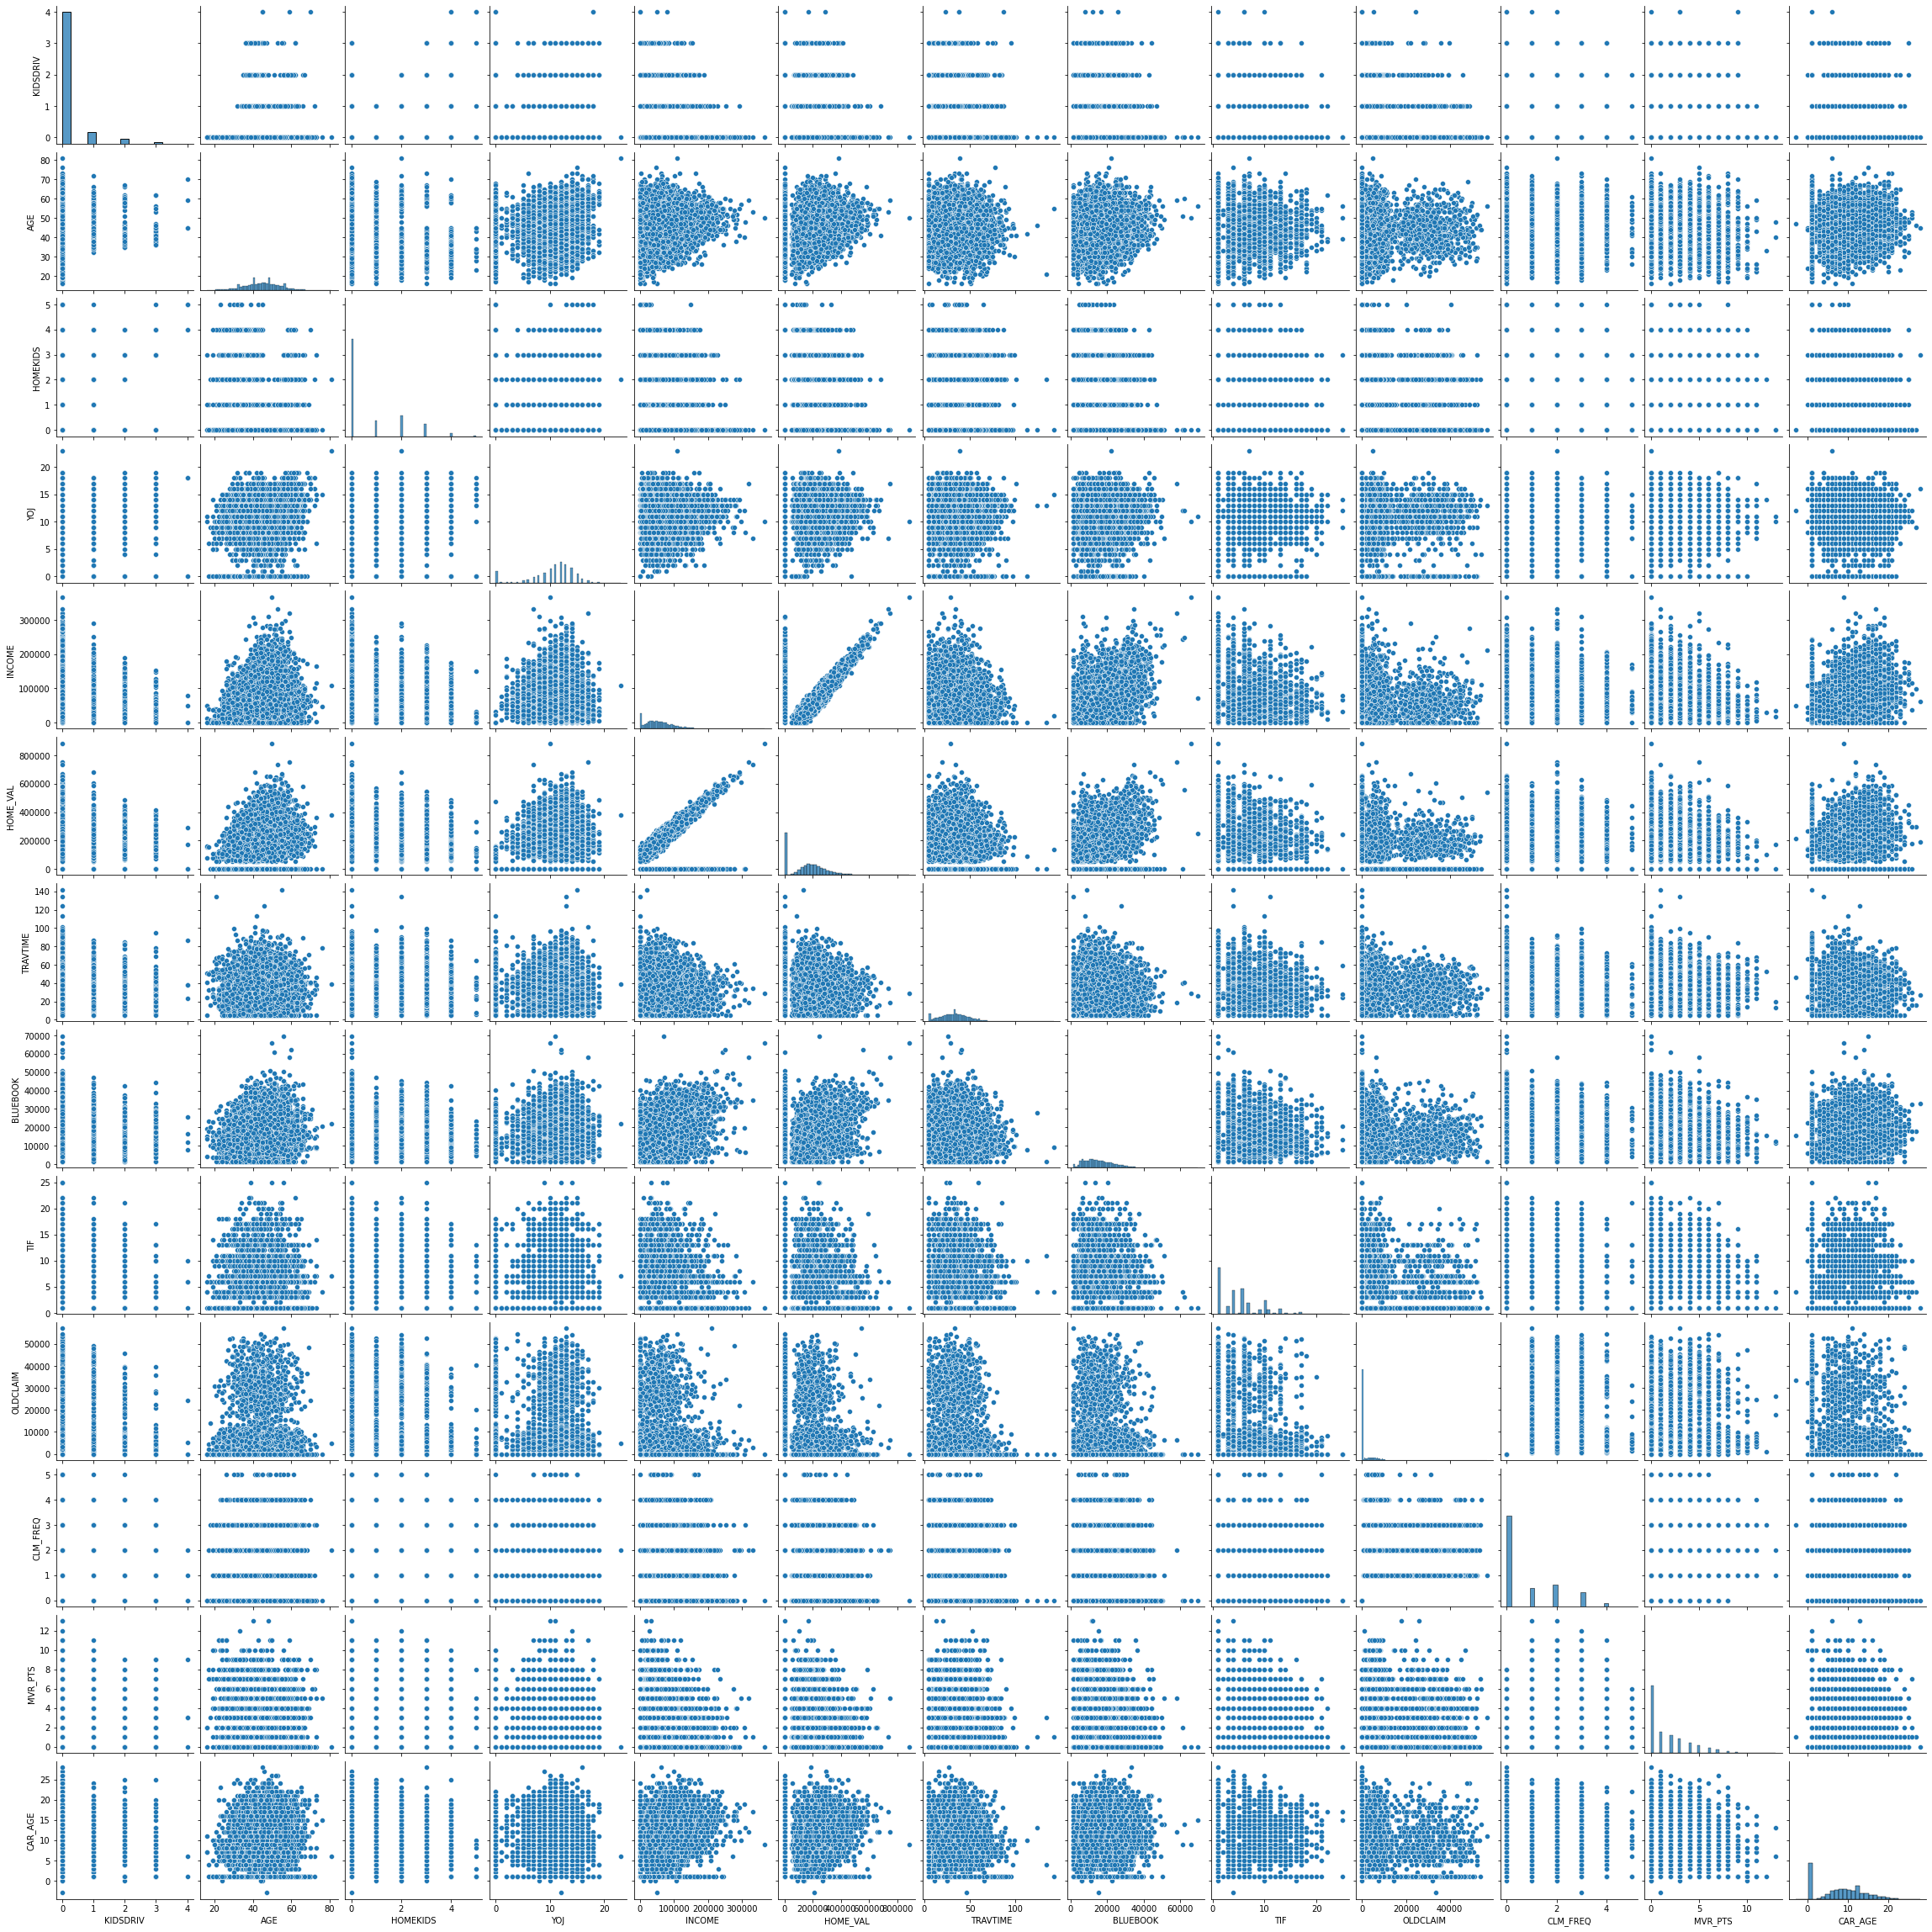

In [ ]:
sns.pairplot(xtrain_)
plt.show()

# **Correlation**

In [ ]:
train = preprocess(train)

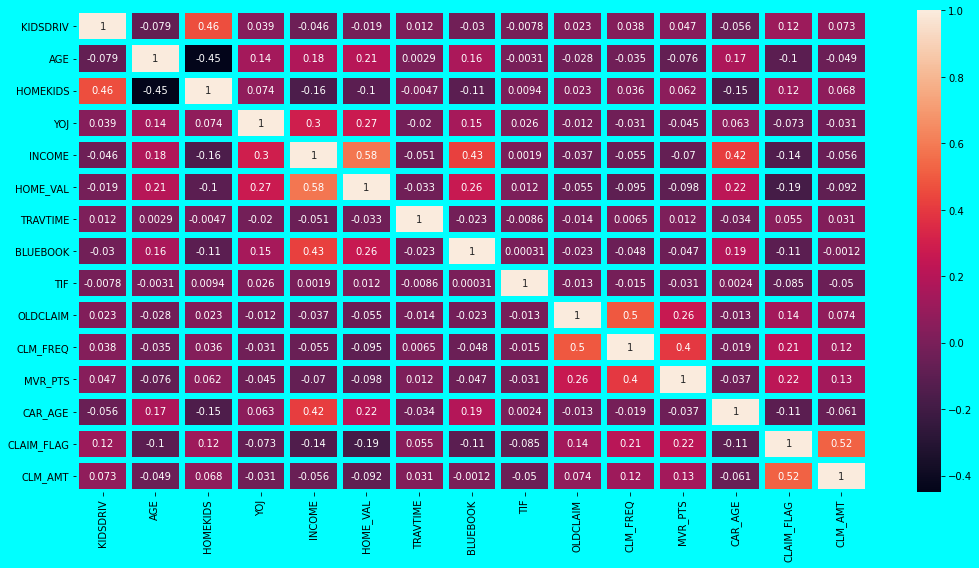

In [ ]:
fig,ax = plt.subplots(figsize = (15,8))
fig.set_facecolor('cyan')
sns.heatmap(train.corr(),linewidth = 5,annot = True,ax = ax,linecolor = 'cyan')
fig.tight_layout()
fig.savefig('corr_analysis.png',bbox_inches = 'tight')
plt.show()

# **Explortory Analysis**

In [ ]:
for i in cat_features:
  display(train.groupby(i)['CLM_AMT'].agg(['mean']).sort_values(by = 'mean'))
  print()

,mean
PARENT1,
No,1347.023391
Yes,2668.436608


,mean
MSTATUS,
Yes,1193.208162
z_No,2007.492671


,mean
GENDER,
z_F,1487.227191
M,1551.179972


,mean
EDUCATION,
PhD,1090.101415
Masters,1102.238581
Bachelors,1465.143080
z_High School,1800.190692
<High School,1898.367061


,mean
OCCUPATION,
Doctor,563.489655
Manager,663.641543
Lawyer,1011.406318
Home Maker,1316.633858
Professional,1527.092116
Clerical,1619.661290
Student,2032.796273
z_Blue Collar,2080.721383


,mean
CAR_USE,
Private,1167.145175
Commercial,2116.048595


,mean
CAR_TYPE,
Minivan,945.539134
z_SUV,1567.175581
Pickup,1753.927545
Sports Car,1801.189542
Van,1805.223267
Panel Truck,1924.545692


,mean
RED_CAR,
no,1500.041591
yes,1557.876631


,mean
REVOKED,
No,1387.096354
Yes,2456.746441


,mean
URBANICITY,
z_Highly Rural/ Rural,384.584926
Highly Urban/ Urban,1795.414247


In [ ]:
def plot_groupby_result(agg_column,agg_func,ncols,suptitle,figsize = (17,7), as_pct = False, modified = False,name = 'figure.png'): 
  cols = ncols
  rows = np.int(np.ceil(len(cat_features)/cols))
  fig, axs = plt.subplots(rows,cols, figsize=figsize)
  feature_index = 0
  for i in range(rows):
    for j in range(cols):
      if modified:
        grouped = (train.groupby(agg_column,dropna = False)[cat_features[feature_index]]
                  .agg(agg_func)
                  .sort_values(ascending = False)[1]/len(train[train.CLAIM_FLAG == 1]))
      else:
        grouped = train.groupby(cat_features[feature_index],dropna = False)[agg_column].agg(agg_func).sort_values(ascending = False)
      if as_pct:
        grouped = grouped/len(train)
      grouped.plot.bar(ax=axs[i,j],xlabel = '')
      axs[i,j].set_title(cat_features[feature_index], size=12, fontweight='bold')
      feature_index += 1
      if feature_index == len(cat_features):
        break
  fig.suptitle(suptitle, size=20, fontweight='bold', y=1.02)
  fig.tight_layout()
  fig.savefig(name, bbox_inches = 'tight')
  fig.show()

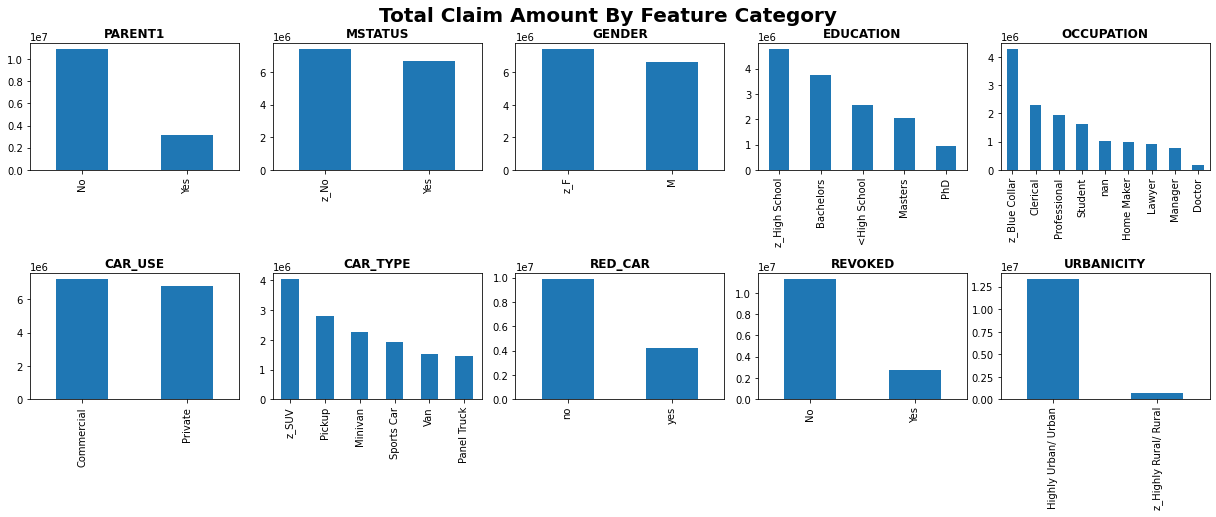

In [ ]:
plot_groupby_result('CLM_AMT',np.sum,5,'Total Claim Amount By Feature Category')

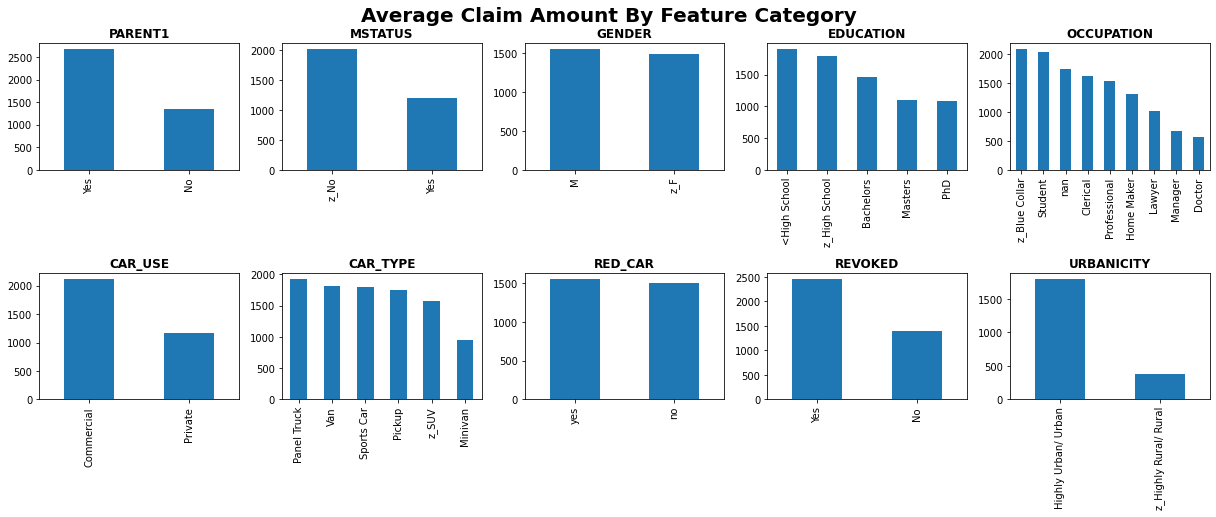

In [ ]:
plot_groupby_result('CLM_AMT',np.mean,5,'Average Claim Amount By Feature Category',name = 'avg_claim.png')

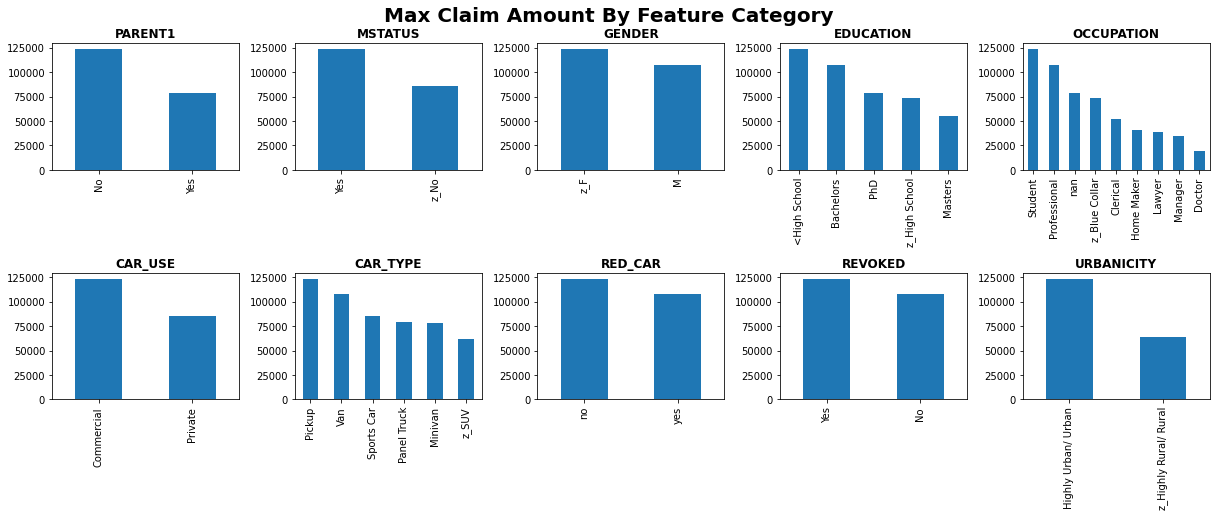

In [ ]:
plot_groupby_result('CLM_AMT',np.max,5,'Max Claim Amount By Feature Category')

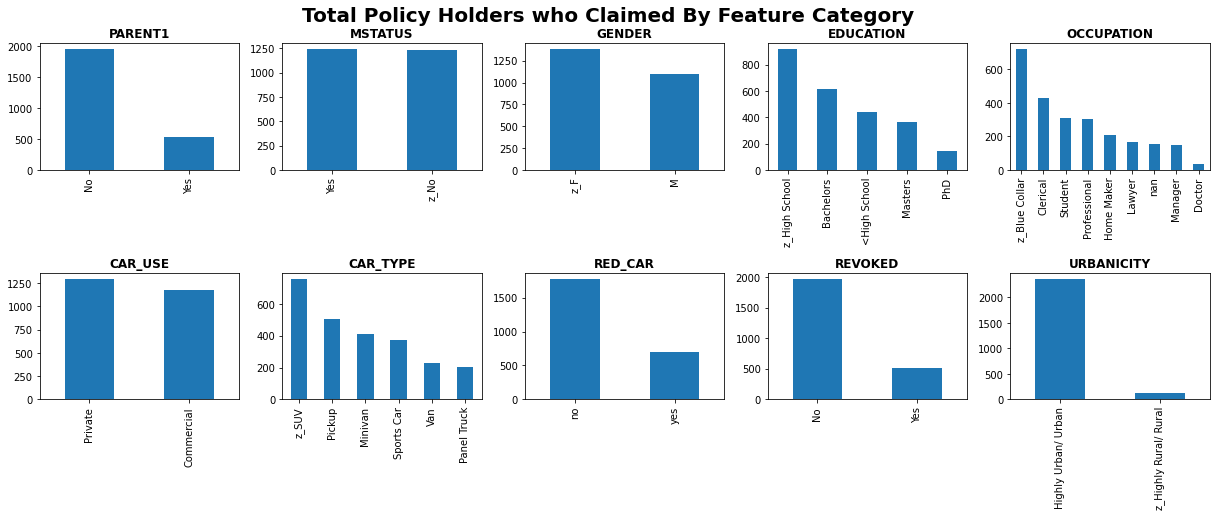

In [ ]:
plot_groupby_result('CLAIM_FLAG',np.sum,5,'Total Policy Holders who Claimed By Feature Category')

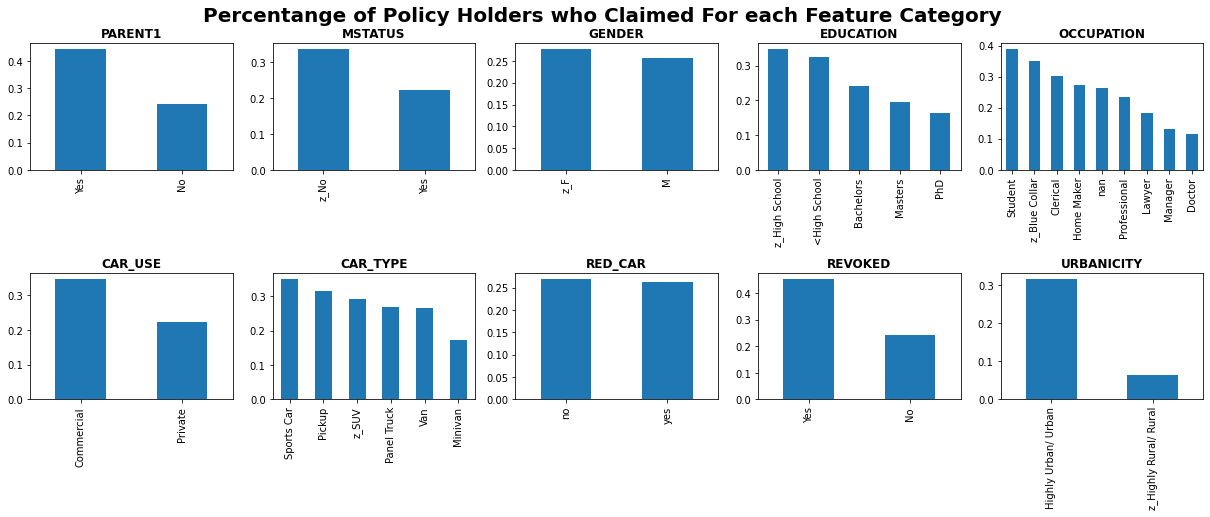

In [ ]:
plot_groupby_result('CLAIM_FLAG',np.mean,5,'Percentange of Policy Holders who Claimed For each Feature Category')

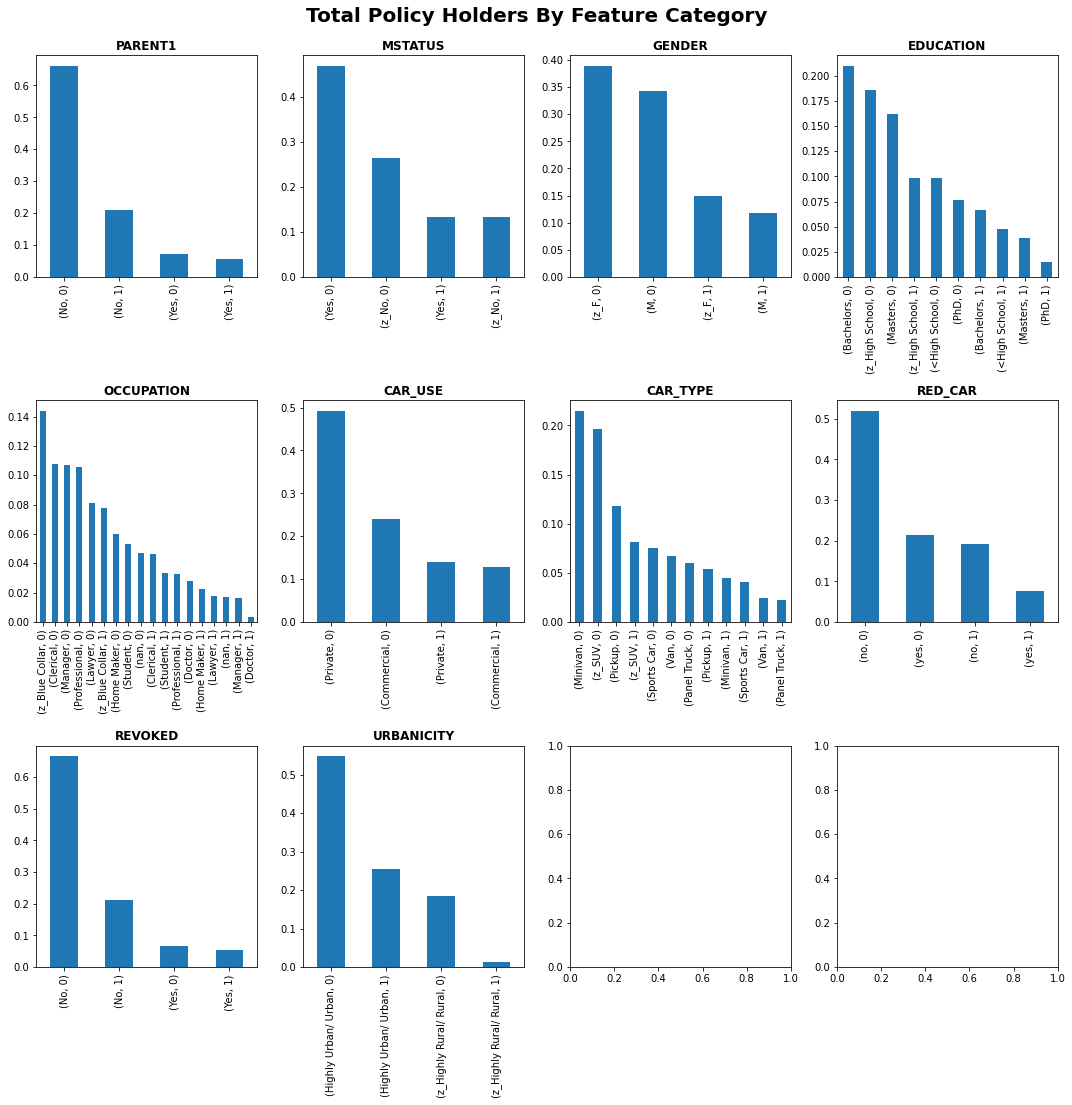

In [ ]:
plot_groupby_result('CLAIM_FLAG','value_counts',4,'Total Policy Holders By Feature Category',figsize = (15,15),as_pct=True)

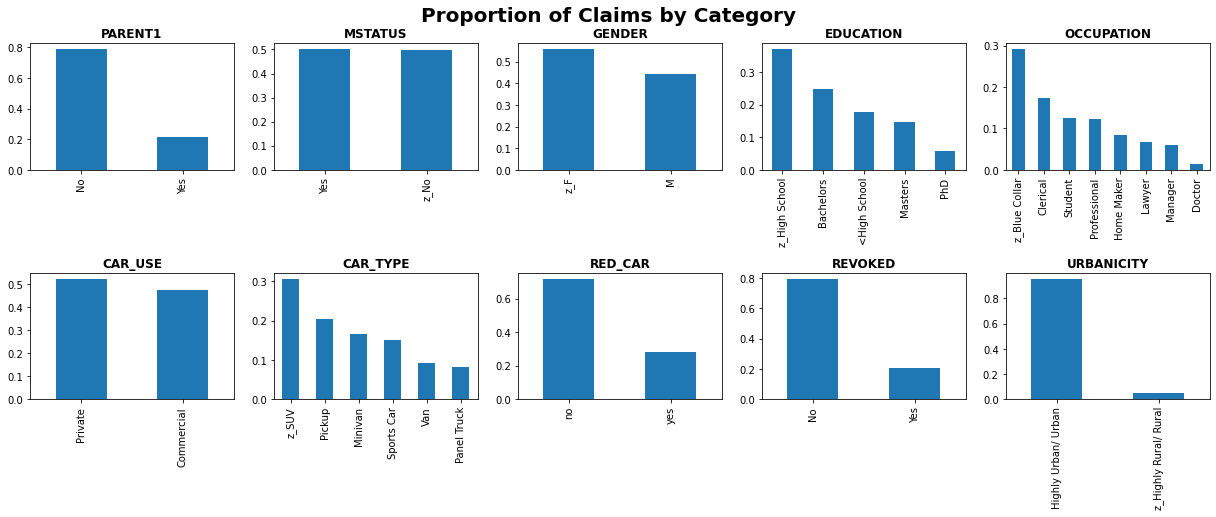

In [ ]:
plot_groupby_result('CLAIM_FLAG','value_counts', 5, 'Proportion of Claims by Category',modified = True)

# **Pipeline**

In [ ]:
def transformation_steps():
  pipe = pipeline.Pipeline([
                  ('cat_bespoke_imputer', imputation.CategoricalImputer()),
                  ('rare_label_encoder', encoding.RareLabelEncoder(0.05, n_categories=1)),
                  ('fe', encoding.CountFrequencyEncoder()),
                  ('knn_imputer',impute.KNNImputer()),
                  ('minmax',preprocessing.MinMaxScaler()),
                  ('cubrt',transformation.PowerTransformer(exp=1/3)),
  ])
  return pipe

In [ ]:
xtrain = preprocess(xtrain)
pipe = transformation_steps()
pipe.fit(xtrain,ytrain_claim)

Pipeline(memory=None,
         steps=[('cat_bespoke_imputer',
                 CategoricalImputer(fill_value='Missing', ignore_format=False,
                                    imputation_method='missing',
                                    return_object=False, variables=None)),
                ('rare_label_encoder',
                 RareLabelEncoder(ignore_format=False, max_n_categories=None,
                                  n_categories=1, replace_with='Rare', tol=0.05,
                                  variables=None)),
                ('fe',
                 CountFrequencyEncoder(encoding_method='count',
                                       ignore_format=False, variables=None)),
                ('knn_imputer',
                 KNNImputer(add_indicator=False, copy=True,
                            metric='nan_euclidean', missing_values=nan,
                            n_neighbors=5, weights='uniform')),
                ('minmax', MinMaxScaler(copy=True, feature_range=(0, 1))),
 

In [ ]:
transformed = pipe.fit_transform(xtrain,ytrain_claim)
transformed.columns = xtrain.columns
transformed

,KIDSDRIV,AGE,HOMEKIDS,YOJ,INCOME,PARENT1,HOME_VAL,MSTATUS,GENDER,EDUCATION,OCCUPATION,TRAVTIME,CAR_USE,BLUEBOOK,TIF,CAR_TYPE,RED_CAR,OLDCLAIM,CLM_FREQ,REVOKED,MVR_PTS,CAR_AGE,URBANICITY
0,0.000000,0.813551,0.000000,0.703268,0.634395,1.0,0.000000,0.0,0.0,0.826384,0.557206,0.498780,0.0,0.656066,0.592816,0.360518,0.0,0.000000,0.000000,1.0,0.000000,0.891977,1.0
1,0.000000,0.821227,0.000000,0.000000,0.000000,1.0,0.000000,1.0,0.0,0.655685,0.663516,0.559539,1.0,0.423957,0.592816,0.966159,0.0,0.000000,0.000000,1.0,0.425290,0.636663,0.0
2,0.000000,0.736806,0.000000,0.805041,0.720742,1.0,0.758159,1.0,0.0,0.826384,0.557206,0.622202,0.0,0.640611,0.500000,0.360518,1.0,0.754724,0.843433,1.0,0.772804,0.802145,1.0
3,0.793701,0.736806,0.736806,0.567336,0.000000,0.0,0.000000,0.0,1.0,0.985300,0.663516,0.602745,0.0,0.623242,0.629961,0.966159,1.0,0.000000,0.000000,1.0,0.425290,0.662156,0.0
4,0.000000,0.789609,0.000000,0.826809,0.384643,1.0,0.564878,1.0,0.0,0.655685,0.863725,0.417920,1.0,0.565032,0.550321,0.966159,1.0,0.383619,0.584804,1.0,0.535832,0.662156,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9266,0.000000,0.797750,0.000000,0.805041,0.531434,1.0,0.638320,0.0,1.0,1.000000,1.000000,0.737702,0.0,0.534323,0.793701,1.000000,1.0,0.000000,0.000000,1.0,0.000000,0.505320,0.0
9267,0.000000,0.781297,0.000000,0.805041,0.424656,1.0,0.000000,0.0,1.0,1.000000,0.863725,0.728649,1.0,0.479219,0.000000,0.551934,1.0,0.532207,0.584804,1.0,0.613375,0.728797,1.0
9268,0.000000,0.651808,0.000000,0.782027,0.277061,1.0,0.000000,1.0,0.0,1.000000,0.663516,0.589041,0.0,0.515350,0.500000,0.772117,0.0,0.466864,0.843433,1.0,0.675106,0.505320,1.0
9269,0.000000,0.497423,0.843433,0.867204,0.328433,1.0,0.490923,1.0,1.0,1.000000,0.863725,0.622202,1.0,0.000000,0.592816,1.000000,1.0,0.384015,0.736806,1.0,0.675106,0.505320,1.0


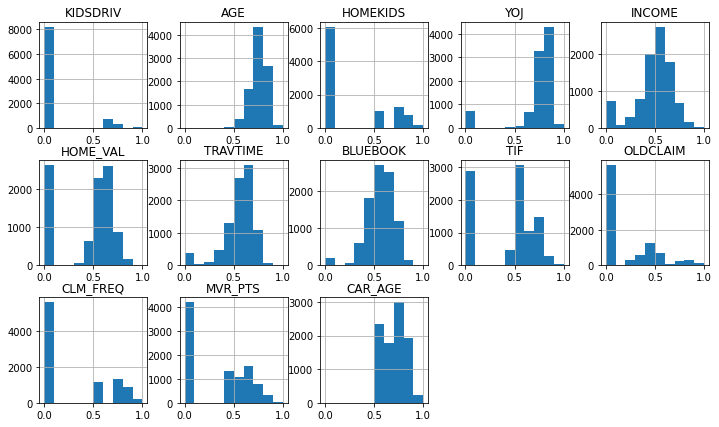

In [ ]:
transformed[num_features].hist(figsize = (12,7),layout = (3,5),)
plt.title('Variable Distribution')
plt.savefig('transformed.png')
plt.show()

# **Smote**

In [ ]:
pd.DataFrame(ytrain_claim.value_counts())

,CLAIM_FLAG
0,6794
1,2477


In [ ]:
smote = SMOTE()
x,y = smote.fit_resample(transformed,ytrain_claim)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
np.unique(y,return_counts= True)

(array([0, 1]), array([6794, 6794]))

In [ ]:
pd.DataFrame(pd.Series(y,name = 'CLAIM_FLAG').value_counts())

,CLAIM_FLAG
1,6794
0,6794


# **Model Selection**

In [ ]:
estimators = [('knn',neighbors.KNeighborsClassifier()),
                     ('ada',ensemble.AdaBoostClassifier()),
                     ('xgb',xgboost.XGBClassifier()),
                     ('lgb',lightgbm.LGBMClassifier())]

In [ ]:
def create_list_of_models():
  models = []
  names = []
  models.append(neighbors.KNeighborsClassifier())
  names.append('knn')
  models.append(ensemble.AdaBoostClassifier())
  names.append('ada')
  models.append(ensemble.BaggingClassifier())
  names.append('bag')
  models.append(ensemble.RandomForestClassifier())
  names.append('rf')
  models.append(xgboost.XGBClassifier())
  names.append('xg')
  models.append(lightgbm.LGBMClassifier())
  names.append('lgb')
  models.append(ensemble.VotingClassifier(estimators, n_jobs = -1))
  names.append('hv')
  models.append(ensemble.VotingClassifier(estimators, n_jobs = -1,voting = 'soft'))
  names.append('sv')
  models.append(ensemble.StackingClassifier(estimators))
  names.append('stacking')
  return models, names

In [ ]:
def create_pipelines(names, models):
  pipelines = []
  for i, j in zip(names,models):
    pipe =  pipeline.Pipeline([
                (i, j)
])
    pipelines.append(pipe)
  return pipelines

In [ ]:
def print_results(results:dict,scorer:str):
  print(f"min {scorer} score = {np.min(results[scorer])}")
  print(f"median {scorer} score = {np.median(results[scorer])}")
  print(f"mean {scorer} = {np.mean(results[scorer])}")
  print(f"max {scorer} = {np.max(results[scorer])}\n")

In [ ]:
def compare_models(names, pipelines, x,y,n_splits = 15):
  accuracy_scores = []
  recall_scores   = []
  precision_scores  = []
  f1_scores = []

  cv = model_selection.ShuffleSplit(n_splits=n_splits, test_size=0.1, random_state=0)

  for name, pipe in zip(names,pipelines):
    print(f'Cross Validation for {name}')
    results = model_selection.cross_validate(pipe,x,y, cv=cv, verbose=1, n_jobs=-1, scoring= ['recall','precision','f1','accuracy'])
    accuracy_scores.append(results['test_precision'])
    recall_scores.append(results['test_recall'])
    f1_scores.append(results['test_f1'])
    precision_scores.append(results['test_precision'])
    

    scorers = ['test_accuracy','test_recall','test_precision','test_f1']
    for i in scorers:
      print_results(results,i)
  
  return recall_scores, precision_scores, f1_scores, accuracy_scores

In [ ]:
def plot_comparison(scores:list,score_names:list,xticklabels,width = 12, height = 6, ncols = 2):
  nrows = int(np.ceil(len(scores)/ncols))
  plt.style.use('fivethirtyeight')
  fig, ax = plt.subplots(nrows=nrows,ncols = ncols, figsize = (width,height))
  counter = 0
  for i in range(nrows):
    for j in range(ncols):
      ax[i,j].boxplot(scores[counter])
      ax[i,j].set_title(score_names[counter], fontweight = 'bold', size = 14)
      ax[i,j].set_xticklabels(xticklabels)
      counter += 1
      if counter >= len(scores):
        break
  fig.suptitle('Comparison of Classification Models', y = 1.02, fontweight = 'bold', size = 20)
  fig.tight_layout()
  fig.savefig('Model Selection.png', bbox_inches = 'tight')

In [ ]:
models, names  = create_list_of_models()
pipelines = create_pipelines(names,models)
scores = compare_models(names,pipelines,x,y,n_splits=10)

Cross Validation for knn


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.7740986019131715
median test_accuracy score = 0.7862398822663723
mean test_accuracy = 0.7857983811626197
max test_accuracy = 0.7969094922737306

min test_recall score = 0.8762886597938144
median test_recall score = 0.9060081979790009
mean test_recall = 0.902579075046974
max test_recall = 0.9255952380952381

min test_precision score = 0.7023370233702337
median test_precision score = 0.7307061908104933
mean test_precision = 0.7315702038180545
max test_precision = 0.7536407766990292

min test_f1 score = 0.7881297446514838
median test_f1 score = 0.8095254761688099
mean test_f1 = 0.8079996859385712
max test_f1 = 0.8240396530359356

Cross Validation for ada


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.7821927888153054
median test_accuracy score = 0.7939661515820455
mean test_accuracy = 0.7973509933774834
max test_accuracy = 0.8160412067696836

min test_recall score = 0.7795620437956204
median test_recall score = 0.803773204196933
mean test_recall = 0.8053086382918847
max test_recall = 0.8303303303303303

min test_precision score = 0.772189349112426
median test_precision score = 0.7980056835481579
mean test_precision = 0.7927758271660947
max test_precision = 0.8078668683812406

min test_f1 score = 0.7817109144542773
median test_f1 score = 0.7974415255114362
mean test_f1 = 0.7988504128485856
max test_f1 = 0.8156342182890854

Cross Validation for bag


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8123620309050773
median test_accuracy score = 0.8381162619573216
mean test_accuracy = 0.8362766740250185
max test_accuracy = 0.8484179543782193

min test_recall score = 0.7777777777777778
median test_recall score = 0.815204904676552
mean test_recall = 0.8098505594135803
max test_recall = 0.8321060382916053

min test_precision score = 0.8292682926829268
median test_precision score = 0.8563413684471346
mean test_precision = 0.8548278109071274
max test_precision = 0.879284649776453

min test_f1 score = 0.8045977011494253
median test_f1 score = 0.8356195484715448
mean test_f1 = 0.8316324116869968
max test_f1 = 0.8470926058865758

Cross Validation for rf


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   17.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8506254598969831
median test_accuracy score = 0.8708609271523179
mean test_accuracy = 0.869168506254599
max test_accuracy = 0.8793230316409124

min test_recall score = 0.8432203389830508
median test_recall score = 0.8806418793932667
mean test_recall = 0.8726716977848865
max test_recall = 0.8880706921944035

min test_precision score = 0.8380809595202399
median test_precision score = 0.8670601041577735
mean test_precision = 0.8665219403456124
max test_precision = 0.8862690707350902

min test_f1 score = 0.854688618468146
median test_f1 score = 0.8712877837614543
mean test_f1 = 0.8694919993177367
max test_f1 = 0.8856548856548856

Cross Validation for xg


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   10.3s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8241353936718175
median test_accuracy score = 0.8440029433406917
mean test_accuracy = 0.8415746872700515
max test_accuracy = 0.8557763061074319

min test_recall score = 0.8102189781021898
median test_recall score = 0.8326449718416478
mean test_recall = 0.8320810364347864
max test_recall = 0.8558823529411764

min test_precision score = 0.8266871165644172
median test_precision score = 0.8513192918805094
mean test_precision = 0.8482689807209516
max test_precision = 0.8757396449704142

min test_f1 score = 0.8212415856394913
median test_f1 score = 0.8414684937771535
mean test_f1 = 0.8399553297582024
max test_f1 = 0.8558823529411764

Cross Validation for lgb


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8359087564385578
median test_accuracy score = 0.8623988226637234
mean test_accuracy = 0.8593818984547461
max test_accuracy = 0.8771155261221486

min test_recall score = 0.7985185185185185
median test_recall score = 0.8422906143066645
mean test_recall = 0.8337843855028293
max test_recall = 0.8601190476190477

min test_precision score = 0.8610223642172524
median test_precision score = 0.8784404956745382
mean test_precision = 0.87882447477007
max test_precision = 0.9

min test_f1 score = 0.8285933897002306
median test_f1 score = 0.8587664814209437
mean test_f1 = 0.8555623395527734
max test_f1 = 0.8733889310083396

Cross Validation for hv


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   28.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8307579102281089
median test_accuracy score = 0.8532008830022075
mean test_accuracy = 0.846504782928624
max test_accuracy = 0.8587196467991169

min test_recall score = 0.7956204379562044
median test_recall score = 0.8270505583720971
mean test_recall = 0.8193192265951842
max test_recall = 0.8407738095238095

min test_precision score = 0.8527508090614887
median test_precision score = 0.8625108247580799
mean test_precision = 0.8663995317362465
max test_precision = 0.890881913303438

min test_f1 score = 0.8254211332312406
median test_f1 score = 0.8445897841735344
mean test_f1 = 0.842102824616701
max test_f1 = 0.8569374550682961

Cross Validation for sv


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   27.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


min test_accuracy score = 0.8454746136865342
median test_accuracy score = 0.8605592347314202
mean test_accuracy = 0.8588668138337013
max test_accuracy = 0.869757174392936

min test_recall score = 0.864406779661017
median test_recall score = 0.8951295085244311
mean test_recall = 0.8925006552232331
max test_recall = 0.9166666666666666

min test_precision score = 0.8150782361308677
median test_precision score = 0.8369048611690153
mean test_precision = 0.8362705193562217
max test_precision = 0.8520475561426685

min test_f1 score = 0.8487031700288185
median test_f1 score = 0.8644938518554879
mean test_f1 = 0.8633689685873269
max test_f1 = 0.8743789921930446

Cross Validation for stacking
min test_accuracy score = 0.8469462840323767
median test_accuracy score = 0.8708609271523179
mean test_accuracy = 0.8682119205298013
max test_accuracy = 0.8852097130242825

min test_recall score = 0.8296296296296296
median test_recall score = 0.863606044411082
mean test_recall = 0.8615692792650333
max test_

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:  2.4min finished


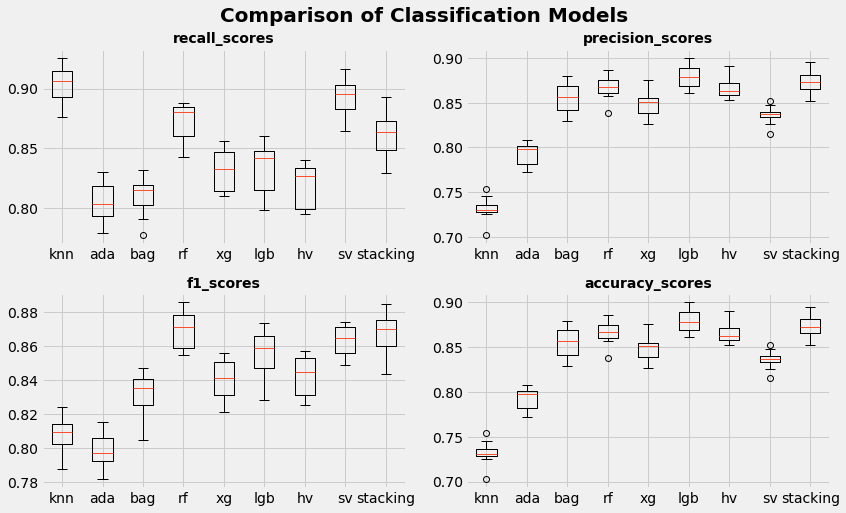

In [ ]:
plot_comparison(scores,['recall_scores', 'precision_scores', 'f1_scores', 'accuracy_scores'],names,height = 7)

Random Forest has performed better and it has been chosen

# **Feature Selection**

In [ ]:
def feature_selection_pipe(i:int, score_func = feature_selection.mutual_info_classif):
  pipe = pipeline.Pipeline([
                            ('kbest',feature_selection.SelectKBest(score_func=score_func,k = i)),
                            ('rf', ensemble.RandomForestClassifier())
  ])
  return pipe

## **Mutual Information**

In [ ]:
mi = feature_selection.mutual_info_classif(x,y)

In [ ]:
pd.DataFrame({
    'features': xtrain.columns,
    'mi': mi
}).sort_values('mi',ascending = False
).style.bar(subset = ['mi'], color = 'grey')

,features,mi
1,AGE,0.277315
11,TRAVTIME,0.273769
21,CAR_AGE,0.232506
3,YOJ,0.227548
10,OCCUPATION,0.184257
20,MVR_PTS,0.183573
14,TIF,0.176809
9,EDUCATION,0.159613
15,CAR_TYPE,0.135905
18,CLM_FREQ,0.106152


In [ ]:
x.shape[1]+1

24

In [ ]:
mi_recall_scores = []
rs = model_selection.ShuffleSplit(5,0.2,random_state=456)
for i in range(1,x.shape[1]+1):
  print(i)
  mi_pipe = feature_selection_pipe(i)
  results = model_selection.cross_validate(mi_pipe,x,y,scoring='recall',cv = rs)
  mi_recall_scores.append(results['test_score'])
  print_results(results,'test_score')

1
min test_score score = 0.6077554064131245
median test_score score = 0.6148308135349172
mean test_score = 0.6186701202112689
max test_score = 0.6387832699619772

2
min test_score score = 0.665946724262059
median test_score score = 0.6756152125279642
mean test_score = 0.6777749412993744
max test_score = 0.6879588839941263

3
min test_score score = 0.6755395683453237
median test_score score = 0.6882923191648024
mean test_score = 0.6894478143175434
max test_score = 0.7019011406844107

4
min test_score score = 0.6972408650260999
median test_score score = 0.7055435565154787
mean test_score = 0.7068563903559792
max test_score = 0.7178707224334601

5
min test_score score = 0.7129008202833707
median test_score score = 0.7185025197984162
mean test_score = 0.7216125973105294
max test_score = 0.7368821292775666

6
min test_score score = 0.7071942446043166
median test_score score = 0.7136465324384788
mean test_score = 0.7259579213008376
max test_score = 0.7619771863117871

7
min test_score score 

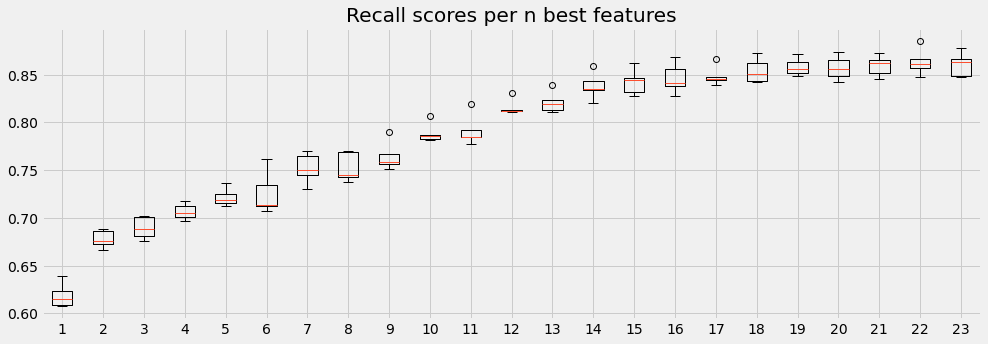

In [ ]:
plt.figure(figsize = (15,5))
plt.boxplot(mi_recall_scores)
plt.title('Recall scores per n best features')
plt.show()

# **Multivariate Feature Importance**

In [ ]:
rf = ensemble.RandomForestClassifier(random_state=745,verbose=1,n_jobs=-1)
rf.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    1.9s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=745, verbose=1,
                       warm_start=False)

In [ ]:
(pd.DataFrame({'features': xtrain.columns, 'importance': rf.feature_importances_})
        .sort_values(by = 'importance',ascending = False)
        .style
        .bar(subset = ['importance'], color = 'grey'))

,features,importance
22,URBANICITY,0.075500
4,INCOME,0.072763
6,HOME_VAL,0.069466
13,BLUEBOOK,0.066473
11,TRAVTIME,0.064222
17,OLDCLAIM,0.060403
1,AGE,0.058831
20,MVR_PTS,0.058798
21,CAR_AGE,0.057109
10,OCCUPATION,0.055401


# **Hyperparameter Tuning**

In [ ]:
param_grid = {
    'max_depth': [10,20,30,50],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,3,5],
    'n_estimators': [80,100,150]
}

In [ ]:
rs = model_selection.ShuffleSplit(3,0.2,random_state=425)
grid = model_selection.GridSearchCV(rf,param_grid,scoring='recall',n_jobs = -1,cv = rs,verbose = 1)

In [ ]:
grid.fit(x,y)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 324 out of 324 | elapsed:  8.3min finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.8s finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=425, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samp...
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=-1,
                                       

In [ ]:
grid.best_params_

{'max_depth': 20,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [ ]:
grid.best_score_

0.867664498995813

# **Random Forest Model**

In [ ]:
rf = grid.best_estimator_
rf.fit(x,y)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:    2.8s finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=20, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=-1, oob_score=False, random_state=745, verbose=1,
                       warm_start=False)

In [ ]:
import joblib

In [ ]:
joblib.dump(pipe,'/content/drive/MyDrive/Research Models/insurance_claims_classification_pipe.sav')

['/content/drive/MyDrive/Research Models/insurance_claims_classification_pipe.sav']

In [ ]:
joblib.dump(rf,'/content/drive/MyDrive/Research Models/insurance_claims_classification.sav')

['/content/drive/MyDrive/Research Models/insurance_claims_classification.sav']

# **Predictions**

In [ ]:
classification_pipe = joblib.load('/content/drive/MyDrive/Research Models/insurance_claims_classification_pipe.sav')

In [ ]:
model = joblib.load('/content/drive/MyDrive/Research Models/insurance_claims_classification.sav')

In [ ]:
xtest = preprocess(xtest)

In [ ]:
xtest_transformed = classification_pipe.transform(xtest)

In [ ]:
claim_pred = model.predict(xtest_transformed)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 150 out of 150 | elapsed:    0.1s finished


In [ ]:
print(metrics.classification_report(ytest_claim,claim_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86       762
           1       0.62      0.55      0.58       269

    accuracy                           0.79      1031
   macro avg       0.73      0.71      0.72      1031
weighted avg       0.79      0.79      0.79      1031



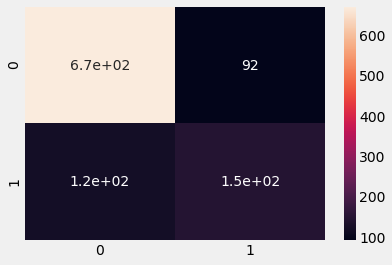

In [ ]:
sns.heatmap(metrics.confusion_matrix(ytest_claim,claim_pred),annot = True)
plt.show()